In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time

if 'path' in locals(): os.chdir(path)
else: os.chdir("../../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/MFI_paper_June24/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.size": 22, "font.family": "serif", "font.serif": ["computer modern roman"]})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

times = r"$\times$"
pwr_neg = r"$^{-1}$"

The path is: /home/ucecabj/Desktop/MFI_git


### Define 1D grid and surface

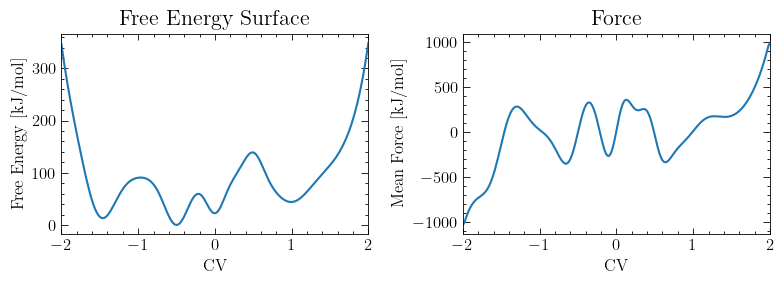

In [3]:
#Define grid and analytical function
x=np.linspace(-2,2,201)
y=1*x**8-50*np.exp(-(x-1)**2/0.1)-93*np.exp(-(x+0.5)**2/0.05)-103*np.exp(-(x+1.5)**2/0.07)-70*np.exp(-(x)**2/0.03)+50*np.exp(-(x-0.5)**2/0.03)
y = y - np.min(y)
dy = np.gradient(y,x)

#Plot function
plt.figure(figsize=(8,3)); plt.rcParams.update({"font.size": 12})
plt.subplot(1,2,1); plt.plot(x,y); plt.xlabel("CV"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface", fontsize=16); plt.xlim(-2,2)
plt.subplot(1,2,2); plt.plot(x,dy); plt.xlabel("CV"); plt.ylabel("Mean Force [kJ/mol]"); plt.title("Force", fontsize=16); plt.xlim(-2,2)
plt.tight_layout(); plt.show()

### Run and analyse simulation

In [3]:
###--- Run simulation
# os.chdir(path_manustript + "Figure1A")
# run_plumed.run_langevin1D(analytical_function = "1*x^8-50*exp(-(x-1)^2/0.1)-93*exp(-(x+0.5)^2/0.05)-103*exp(-(x+1.5)^2/0.07)-70*exp(-(x)^2/0.03)+50*exp(-(x-0.5)^2/0.03)", 
#                           initial_position=-1.5, simulation_steps = 2000000 ,gaus_width=0.1, gaus_height=2.5, biasfactor=20, gaus_pace=100)

20.0 %   OFE = 2.2453
40.0 %   OFE = 1.6781
60.0 %   OFE = 1.4145
80.0 %   OFE = 1.371
100.0 %   OFE = 4.7094


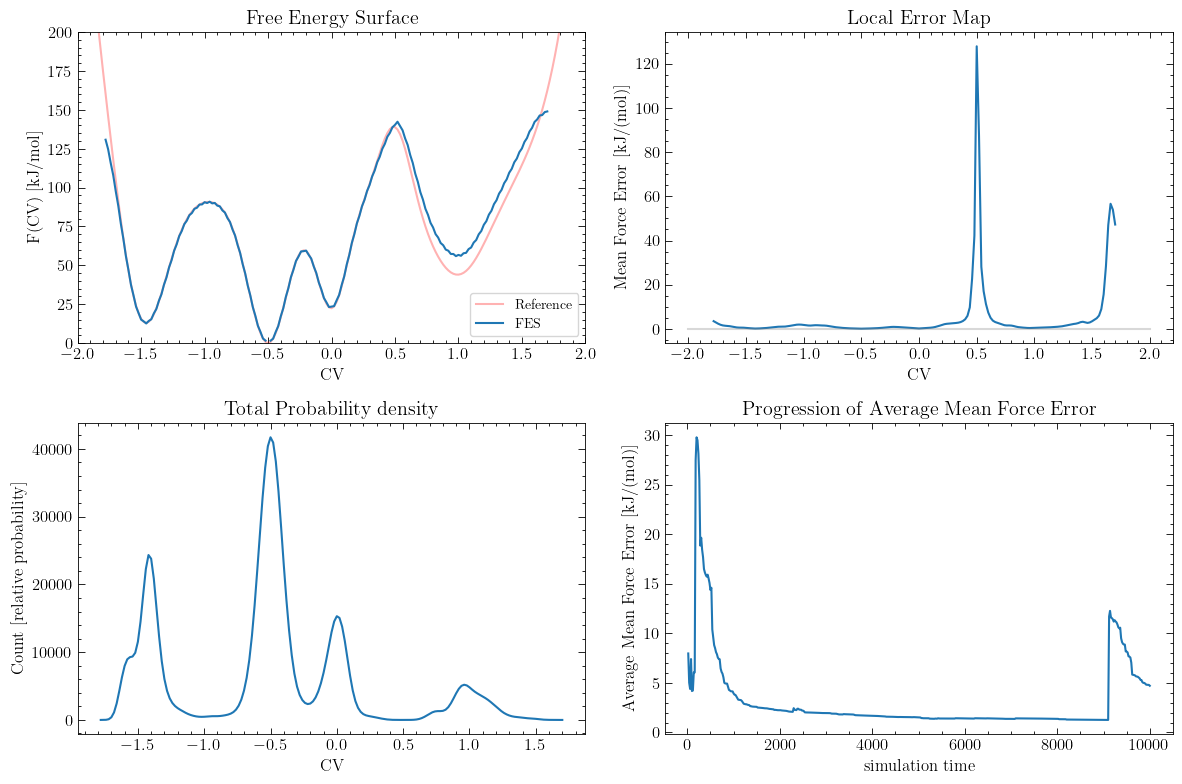

In [4]:
###--- Analyse the data with MFI
#Read the HILLS and Colvar data
os.chdir(path_manustript + "Figure1A")
HILLS=MFI1D.load_HILLS(hills_name="HILLS")
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force and free energy surface
reselts = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.03, log_pace = 4000, error_pace = int(len(HILLS)/500), 
                       FES_cutoff=-1, Ftot_den_cutoff=0.1, save_intermediate_fes_error_cutoff = True, use_weighted_st_dev=False)
X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = reselts

# Integrate Ftot, obtain FES 
FES = MFI1D.intg_1D(Ftot, X[1]-X[0])
FES_dw = np.array(FES)

# Plot Recap
MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES*cutoff), MFI1D.zero_to_nan(Ftot_den*cutoff), MFI1D.zero_to_nan(ofe*cutoff), error_evol[1], error_evol[3], y_ref=y, FES_lim=200, ofe_lim = 0, error_log_scale=0)

# Save data for figure 1 plot
MFI.save_pkl([x, y, FES_dw, ofe, cutoff, error_evol, HILLS], path_manustript +"Figure1/" + "data_figure_1A.pkl")

### Understanding the sampling of a new basin

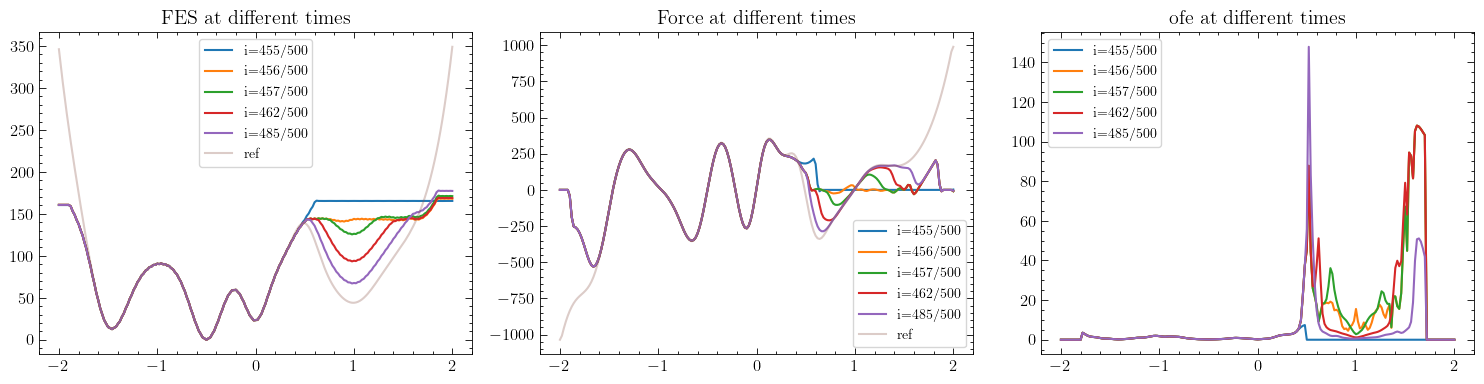

In [8]:
plt.figure(1, figsize=(15,4))
aad_evol = []
aad_v_evol = []
error_index_list = [455, 456, 457, 462, 485, ]
for i in range(len(fes_error_cutoff_evol[0])):
    
    #Find FES and error
    FES = fes_error_cutoff_evol[0,i] 
    AD = abs(FES - y) * fes_error_cutoff_evol[3,i]
    AAD = np.sum(AD) / np.count_nonzero(fes_error_cutoff_evol[3,i])
    volume = np.count_nonzero(fes_error_cutoff_evol[3,i]) / len(fes_error_cutoff_evol[3,i])
    aad_evol.append(AAD)
    aad_v_evol.append(AAD / volume)
    
    # plot FES, Force and Error for selected iterations
    if (i+1) in error_index_list:
        plt.figure(1, figsize=(8,4)) 
        plt.subplot(1,3,1); plt.plot(x,FES, label="i=" + str(i+1)+"/500")
        plt.subplot(1,3,2); plt.plot(x,np.gradient(FES,x), label="i=" + str(i+1)+"/500")
        plt.subplot(1,3,3); plt.plot(x, fes_error_cutoff_evol[2,i], label="i=" + str(i+1)+"/500")
        
#plot reference FES, Force
plt.figure(1, figsize=(8,4))
plt.subplot(1,3,1); plt.plot(x,y, alpha=0.3, label="ref"); plt.title("FES at different times"); plt.legend(fontsize=10)
plt.subplot(1,3,2); plt.plot(x,np.gradient(y,x), alpha=0.3, label="ref"); plt.title("Force at different times"); plt.legend(fontsize=10)
plt.subplot(1,3,3); plt.legend(fontsize=10); plt.title("ofe at different times")
plt.tight_layout(); plt.show()

MFI.save_pkl([error_evol[3], error_evol[1], aad_evol ,error_evol[2]], path_manustript +"Figure4/" + "data_figure_4_1A.pkl")

### Compare OFE, OFE/v, AAD and AAD/v

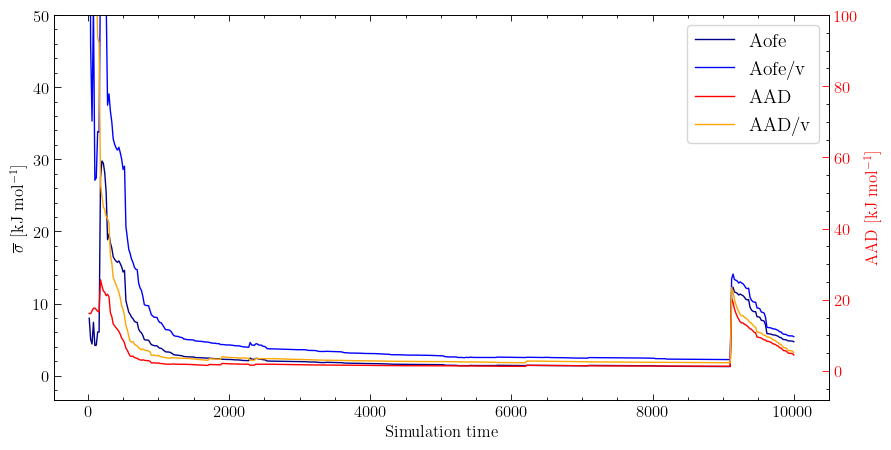

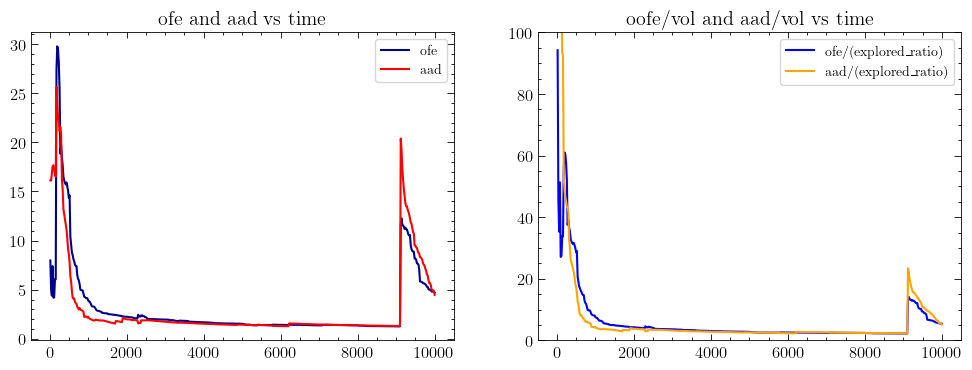

In [9]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot( error_evol[3], error_evol[1], c="darkblue",linewidth=1,label="Aofe")
ax1.plot( error_evol[3], error_evol[1]/error_evol[2] ,c='blue',linewidth=1,label="Aofe/v")
ax2.plot( error_evol[3], aad_evol, c="red" ,linewidth=1,label="AAD")
ax2.plot( error_evol[3], aad_evol/error_evol[2],c="orange",linewidth=1, label="AAD/v")
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]", c="black"); ax2.set_ylabel("AAD [kJ mol$^{-1}$]", c="red"); ax2.tick_params('y', colors='r')
ax1.set_ylim(top=50) ;ax2.set_ylim(top=100)

handles1, labels1 = ax1.get_legend_handles_labels(); handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
plt.show()



plt.figure(3, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(error_evol[3], error_evol[1], c="darkblue", label="ofe")
# plt.scatter(error_evol[3], error_evol[1], c="darkblue",s=3)
plt.plot(error_evol[3], aad_evol, label="aad",c="red")
# plt.scatter(error_evol[3], aad_evol,s=3,c="red")
plt.title("ofe and aad vs time"); plt.legend(fontsize=10); 

plt.subplot(1,2,2)
plt.plot(error_evol[3], error_evol[1]/error_evol[2], c="blue", label="ofe/(explored_ratio)")
# plt.scatter(error_evol[3], error_evol[1]/error_evol[2], c="blue",s=3)
plt.plot(error_evol[3], aad_evol/error_evol[2], label="aad/(explored_ratio)",c="orange")
# plt.scatter(error_evol[3], aad_v_evol,s=3,c="orange")
plt.title("oofe/vol and aad/vol vs time"); plt.legend(fontsize=10); 
plt.ylim(0,100)
plt.show()

### Plot: Figure1A

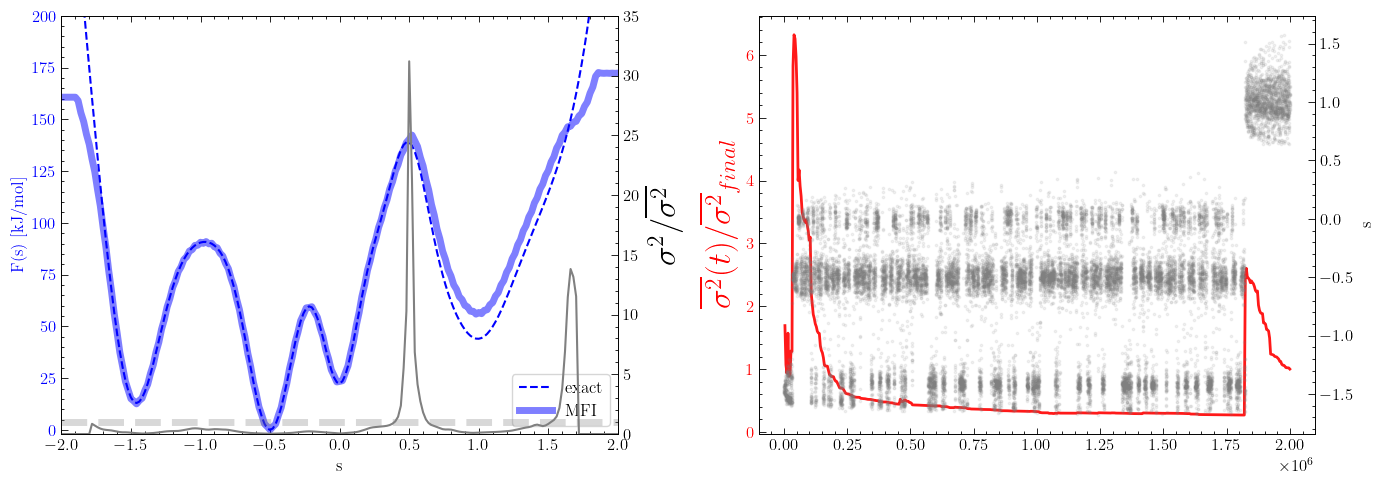

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

#Left plot
axs[0].set_ylabel('F(s) [kJ/mol]',color='blue')
axs[0].set_xlabel('s')
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,200)
axs[0].plot(x, y-min(y),'--',color='blue',label='exact');
axs[0].plot(X, FES,color='blue',linewidth=5,alpha=0.5,label="MFI");
axs[0].tick_params(axis ='y', labelcolor = 'blue')

ax1 = axs[0].twinx()
ax1.set_ylabel('$\sigma^2/\overline{\sigma^2}$', fontsize=24, color='black')
ax1.tick_params(axis ='y', labelcolor = 'black', right = True , labelright = True ) 
ax1.set_ylim(0, 35) 
ax1.plot(X, ofe/np.mean(ofe),color="grey",label="$\sigma^2(s)$");
ax1.plot(X, np.zeros(len(X))+1,'--',linewidth=5,color="grey", alpha=0.3,label="$\overline{\sigma^2(s)}$");

axs[0].legend()

#Right plot
ax2 = axs[1].twinx()

axs[1].plot([time/0.005 for time in error_evol[3]], error_evol[1]/error_evol[1][np.size(error_evol[1])-1],color='red',linewidth=2,alpha=0.9);
axs[1].set_ylabel('$\overline{\sigma^2}(t)/\overline{\sigma^2}_{final}$', fontsize=24, color='red')
axs[1].tick_params(axis ='y', labelcolor = 'red')
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('s',color='black')
ax2.tick_params(axis ='y', labelcolor = 'black')
ax2.scatter(HILLS[:,0]/0.005,HILLS[:,1],color='grey',s=3, alpha=0.1)

fig.tight_layout()    
# plt.savefig('Figure1A', dpi=600, bbox_inches='tight')
plt.show()